## File: radiology_task_analysis.ipynb
#### Summary: This file approximates the amount of time required to complete a task in the O*Net occupation data

#### By: Peyman Shahidi (based on R script by Sam Pomerantz)
#### First Created: May 17, 2024

#### Last Edit by Peyman on May 17, 2024

In [6]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
from itertools import product
from datetime import datetime
epoch = datetime.utcfromtimestamp(0)
from datetime import timedelta
import math as math
import unicodedata
import json
import requests
import gzip
import shutil
import re
from urllib.request import urlopen

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [7]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output/data'
    output_path = f'{main_folder_path}/output/radiology_analysis'

### Functions

In [8]:
def fix_names(name):
    name = name.replace(" ", "_")
    remote = [" ", "\\$", "/", "%", "-", "\\(", "\\)", "\\*"]
    for i in remote:
        name = re.sub(i, "", name)
    name = re.sub("__", "_", name)
    name = name.lower()
    return name


def GPT_prompter(system_role_msg, prompt, temperature, api_key):
    # send request to GPT
    response = requests.post(
        url = "https://api.openai.com/v1/chat/completions",
        headers = {"Authorization": f"Bearer {api_key}"},
        json ={
            "model": "gpt-4-turbo",
            "temperature": temperature,
            "seed": 265,
            "messages": [{"role": "system", "content": system_role_msg},
                         {"role": "user", "content": prompt}
                        ]
        }
    )
    
    # GPT's answer
    answer = response.json()['choices'][0]['message']['content']
    return answer


def extract_numeric(text):
    pattern = r'{answer:\s*([0-9]+\.?[0-9]*)\s*(?:minutes)?}'
    match = re.search(pattern, text)
    return float(match.group(1)) if match else None

### Main Code Starts Here

In [4]:
# Read O*NET data
onet = pd.read_csv(f'{data_path}/onet_occupations_yearly.csv')

#### Restrict attention to Radiologists

In [ ]:
# Keep radiologists
onet = onet[onet["occ_code"] == "29-1224"]

# Standardize task IDs across time
onet['task_id'] = onet.sort_values(by=['task', 'year']).groupby('task')['task_id'].transform('last')
onet.loc[onet['task_id'] == 17152, 'task_id'] = 22736  # these tasks are the same but differ by only a comma

# Keep tasks that appear in 2023
tasks_2023 = onet[onet['year'] == 2023].groupby('task_id').size().reset_index(name='count')['task_id'].tolist()
onet = onet[onet['task_id'].isin(tasks_2023)]

# Drop if missing information
onet = onet.dropna(subset=['yearly_or_less'])

# Aggregate to task level, carry forward non-missing values
onet = onet.sort_values(by='year').groupby(['occ_code', 'occ_title', 'task_id', 'task', 'task_type']).agg(
    yearly_or_less=('yearly_or_less', 'last'),
    more_than_yearly=('more_than_yearly', 'last'),
    more_than_monthly=('more_than_monthly', 'last'),
    more_than_weekly=('more_than_weekly', 'last'),
    daily=('daily', 'last'),
    several_times_daily=('several_times_daily', 'last'),
    hourly_or_more=('hourly_or_more', 'last'),
    task_importance=('task_importance', 'last'),
    task_relevance=('task_relevance', 'last')
).reset_index()


#### Calculate Aggregate Times (note that this is an overestimation)

In [ ]:
# Fork out importance/relevance
weights = onet.groupby(['task_id', 'task_importance', 'task_relevance']).size().reset_index(name='N')

# Keep tasks with frequencies
freqs = onet.dropna(subset=['yearly_or_less'])
freqs = freqs[['task', 'task_id', 'task_type', 'yearly_or_less', 'more_than_yearly',
               'more_than_monthly', 'more_than_weekly', 'daily', 'several_times_daily',
               'hourly_or_more']]

# Reshape
freqs_long = pd.melt(freqs, id_vars=['task', 'task_id', 'task_type'], 
                     value_vars=['yearly_or_less', 'more_than_yearly', 'more_than_monthly',
                                 'more_than_weekly', 'daily', 'several_times_daily', 'hourly_or_more'],
                     var_name='freq_bin', value_name='share')

# Calculate avg freq bin -> assuming 261 working days in a year
freqs_long['share'] /= 100
freqs_long.loc[freqs_long['freq_bin'] == 'yearly_or_less', 'freq_val'] = 1
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_yearly', 'freq_val'] = 3
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_monthly', 'freq_val'] = 18
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_weekly', 'freq_val'] = 78
freqs_long.loc[freqs_long['freq_bin'] == 'daily', 'freq_val'] = 261
freqs_long.loc[freqs_long['freq_bin'] == 'several_times_daily', 'freq_val'] = 1044
freqs_long.loc[freqs_long['freq_bin'] == 'hourly_or_more', 'freq_val'] = 6264
freqs_long['freq_bin_val'] = freqs_long['freq_bin'].map({
    'yearly_or_less': 1,
    'more_than_yearly': 2,
    'more_than_monthly': 3,
    'more_than_weekly': 4,
    'daily': 5,
    'several_times_daily': 6,
    'hourly_or_more': 7
})

freqs_avg = freqs_long.groupby(['task_id', 'task', 'task_type']).apply(
    lambda x: pd.Series({
        'avg_freq_val': (x['freq_val'] * x['share']).sum(),
        'avg_freq_bin': (x['freq_bin_val'] * x['share']).sum()
    })
).reset_index()

freqs_avg['rel_freq'] = freqs_avg['avg_freq_val'] / freqs_avg['avg_freq_val'].sum()
freqs_avg['hours_per_yr'] = freqs_avg['rel_freq'] * 2080

def categorize_freq_bin(avg_freq_bin): # Sam had equalities different for some reason
    if avg_freq_bin <= 1.2:
        return "Yearly or Less"
    elif 1.2 < avg_freq_bin <= 1.8:
        return "Approximately Yearly"
    elif 1.8 < avg_freq_bin <= 2.2:
        return "more than yearly"
    elif 2.2 < avg_freq_bin <= 2.8:
        return "More than Yearly, less than Monthly"
    elif 2.8 < avg_freq_bin <= 3.2:
        return "more than monthly"
    elif 3.2 < avg_freq_bin <= 3.8:
        return "More than monthly, less than weekly"
    elif 3.8 < avg_freq_bin <= 4.2:
        return "more than weekly"
    elif 4.2 < avg_freq_bin <= 4.8:
        return "More than weekly, less than daily"
    elif 4.8 < avg_freq_bin <= 5.2:
        return "daily"
    elif 5.2 < avg_freq_bin <= 5.8:
        return "a few times daily"
    elif 5.8 < avg_freq_bin <= 6.2:
        return "several times daily"
    elif 6.2 < avg_freq_bin <= 6.8:
        return "less than hourly"
    elif avg_freq_bin >= 6.8:
        return "hourly or more"

freqs_avg['freq_bin'] = freqs_avg['avg_freq_bin'].apply(categorize_freq_bin)

task_summary = freqs_avg.rename(columns={'avg_freq_bin': 'freq_bin_val'})
task_summary = task_summary[['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr']]


#### ChatGPT API

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
        {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
    ]
)

completion.choices[0].message

In [ ]:
completion.choices[0].message

In [ ]:
# List of tasks
tasks_list = task_summary['task']


# Prepare prompts to feed GPT
pre1 = "Consider this occupation: Radiologist \n"
pre2 = "Part of this occupation is this task: "

time_to_complete = "How many minutes would it take to do this task, on average? \
Think step-by-step. Return a precise estimated time (i.e., not a range of times) and \
formatted like this: {answer: <put estimated time here>}{comment: <put explanation here>}"

time_w_ai = "Imagine this task can be automated with the use of artificial intelligence. \
The worker is now responsible for inspecting the output of the task. \
What is the ratio of time to evaluate this task relative to the time it takes to do it? \
E.g., if it takes just as long to inspect the output as to do the task, then 1. \
If the task output could be inspected in 5 minutes but the task takes 10 minutes, then 0.5. \
Return a precise estimate ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

prob_auto_prmpt = "Imagine a radiologist is implementing artificial intelligence tools to simplify this task. \
What is the likelihood that this task can be fully automated using AI? \
E.g., if the task can be fully automated with absolute certainty, then 1. \
If the task has a 50% chance of being fully automated, then 0.5.\
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

share_auto_prmpt = "Imagine a radiologist is implementing artificial intelligence tools to simplify this task. \
What amount of work involved in this task could be automated with AI? \
E.g., if the portion of the work for this task that could be automated accounts for \
50% of the total time required, then 0.5. If the task could be fully automated, then 1. \
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

ttc_sys_msg = "You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: a medical doctor approximating the amount of time \
required to complete tasks associated with the practice of medicine."

ai_xprt_sys_msg = "You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert in medical practice and artificial intelligence, \
evaluating the potential assistance artificial intelligence can provide medical doctors in their daily tasks."

In [ ]:
# Initialization
temp = 0.25
task_summary['automation_share_raw'] = ""
task_summary['automation_prob_raw'] = ""
task_summary['comp_time_mins_raw'] = ""
task_summary['review_shr_raw'] = ""


# Run the prompt
i = 1
for task in tasks_list:
    print(f'Task {i}: {task}')
    i += 1

    
    # Completion Times
    # time to complete task
    prompt = f"{pre1}{pre2}{task}\n{time_to_complete}"
    ans = GPT_prompter(system_role_msg=ttc_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'comp_time_mins_raw'] = ans
    

    # time to inspect AI output
    prompt = f"{pre1}{pre2}{task}\n{time_w_ai}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'review_shr_raw'] = ans


    
    # AI contributions
    # likelihood that task can be fully automated
    prompt = f"{pre1}{pre2}{task}\n{prob_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_prob_raw'] = ans


    # share of task that can be automated
    prompt = f"{pre1}{pre2}{task}\n{share_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_share_raw'] = ans

In [ ]:
# Clean up responses
for col in ['automation_share', 'automation_prob', 'comp_time_mins', 'review_shr']:
    print(col)
    task_summary[f'{col}'] = task_summary[f'{col}_raw'].apply(extract_numeric)

# Merge weights into task_summary based on 'task_id'
task_summary = task_summary.merge(weights[['task_id', 'task_importance', 'task_relevance']],
                                  on='task_id', 
                                  how='left')

In [ ]:
# Save output
my_cols = ['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr',
           'comp_time_mins', 'review_shr', 'automation_share', 'automation_prob',
           'task_importance', 'task_relevance']
task_summary.to_csv(f'{output_path}/radiology_task_summary_temp{int(temp*100)}.csv', columns=my_cols, index=False)

# TEST

<br>

<br>

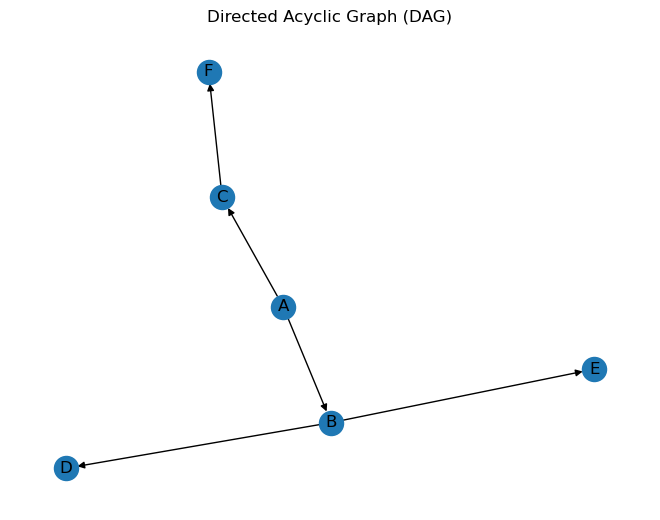

In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the adjacency matrix
adjacency_matrix = np.array([
    [0, 1, 1, 0, 0, 0],  # Node 0 has edges to nodes 1 and 2
    [0, 0, 0, 1, 1, 0],  # Node 1 has edges to nodes 3 and 4
    [0, 0, 0, 0, 0, 1],  # Node 2 has an edge to node 5
    [0, 0, 0, 0, 0, 0],  # Node 3 has no outgoing edges
    [0, 0, 0, 0, 0, 0],  # Node 4 has no outgoing edges
    [0, 0, 0, 0, 0, 0]   # Node 5 has no outgoing edges
])

# Create a directed graph from the adjacency matrix
G = nx.DiGraph(adjacency_matrix)

# Set a random seed for reproducibility
np.random.seed(42)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions (if desired)
# For example, move node 0 to position (0, 0)
pos[0] = (0, 0)

# Modify node labels (if desired)
node_labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F"}

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, labels=node_labels, arrows=True)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()
